In [1]:
# Install necessary libraries
!pip install -q pandas scikit-learn joblib matplotlib seaborn

# Import common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib


In [2]:
# Cell 2 — Load dataset (make sure filename matches Files panel)
FNAME = "mandi_prices.csv"   # change only if your file name differs
df = pd.read_csv(FNAME)
print("Loaded:", FNAME)
print("Rows,Cols:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Loaded: mandi_prices.csv
Rows,Cols: (2000, 14)
Columns: ['Date', 'State', 'District', 'Mandi', 'Commodity', 'Variety', 'Min Price', 'Max Price', 'Modal Price', 'Unit', 'Arrival Quantity', 'Grade', 'Market Fee (%)', 'Trader Count']


,Date,State,District,Mandi,Commodity,Variety,Min Price,Max Price,Modal Price,Unit,Arrival Quantity,Grade,Market Fee (%),Trader Count
0,2024-01-23,Gujarat,Ahmedabad,Main Mandi,Rice,Kolam,1051,1163,1090.0,Quintal,97.71,C,1.84,8
1,2024-03-14,Karnataka,Bangalore,Agro Market,Maize,White,1087,1382,1270.5,Quintal,31.89,B,1.48,10
2,2024-05-23,Maharashtra,Nashik,Agro Market,Wheat,Sharbati,984,1154,1049.0,Quintal,43.95,C,1.18,15
3,2024-05-06,Gujarat,Ahmedabad,Main Mandi,Potato,Kufri Jyoti,897,1216,1014.5,Quintal,45.70,B,2.96,14
4,2024-01-30,Gujarat,Surat,Wholesale Yard,Wheat,Sharbati,973,1140,1012.5,Quintal,82.24,B,1.46,5


In [3]:
# Cell 3 — Drop and rename for consistency
df = df.drop(['Unit', 'Min Price', 'Max Price', 'Market Fee (%)', 'Trader Count'], axis=1, errors='ignore')

df = df.rename(columns={
    'State': 'State_Name',
    'Mandi': 'Market_Name',
    'Modal Price': 'Modal_Price',
    'Arrival Quantity': 'Arrival_Quantity'
})

print("Columns after rename/drop:", df.columns.tolist())
df.head()


Columns after rename/drop: ['Date', 'State_Name', 'District', 'Market_Name', 'Commodity', 'Variety', 'Modal_Price', 'Arrival_Quantity', 'Grade']


,Date,State_Name,District,Market_Name,Commodity,Variety,Modal_Price,Arrival_Quantity,Grade
0,2024-01-23,Gujarat,Ahmedabad,Main Mandi,Rice,Kolam,1090.0,97.71,C
1,2024-03-14,Karnataka,Bangalore,Agro Market,Maize,White,1270.5,31.89,B
2,2024-05-23,Maharashtra,Nashik,Agro Market,Wheat,Sharbati,1049.0,43.95,C
3,2024-05-06,Gujarat,Ahmedabad,Main Mandi,Potato,Kufri Jyoti,1014.5,45.70,B
4,2024-01-30,Gujarat,Surat,Wholesale Yard,Wheat,Sharbati,1012.5,82.24,B


In [4]:
# Cell 4 — Convert Date and extract day/month/year
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows missing essential columns
df = df.dropna(subset=['Date', 'Commodity', 'State_Name', 'Market_Name', 'Modal_Price'])

df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

print("Date range:", df['Date'].min(), "->", df['Date'].max())
df[['Date','Day','Month','Year']].head()


Date range: 2024-01-01 00:00:00 -> 2024-06-29 00:00:00


,Date,Day,Month,Year
0,2024-01-23,23,1,2024
1,2024-03-14,14,3,2024
2,2024-05-23,23,5,2024
3,2024-05-06,6,5,2024
4,2024-01-30,30,1,2024


In [5]:
# Cell 5 — Keep only useful columns
keep = ['Commodity','State_Name','Market_Name','Variety','Grade','Arrival_Quantity',
        'Day','Month','Year','Modal_Price']
df = df[keep].copy()
print("Kept columns:", df.columns.tolist())
df.head()


Kept columns: ['Commodity', 'State_Name', 'Market_Name', 'Variety', 'Grade', 'Arrival_Quantity', 'Day', 'Month', 'Year', 'Modal_Price']


,Commodity,State_Name,Market_Name,Variety,Grade,Arrival_Quantity,Day,Month,Year,Modal_Price
0,Rice,Gujarat,Main Mandi,Kolam,C,97.71,23,1,2024,1090.0
1,Maize,Karnataka,Agro Market,White,B,31.89,14,3,2024,1270.5
2,Wheat,Maharashtra,Agro Market,Sharbati,C,43.95,23,5,2024,1049.0
3,Potato,Gujarat,Main Mandi,Kufri Jyoti,B,45.70,6,5,2024,1014.5
4,Wheat,Gujarat,Wholesale Yard,Sharbati,B,82.24,30,1,2024,1012.5


In [6]:
# Cell 6 — handle missing and numeric conversion
print("Missing before:\n", df.isnull().sum())

df['Arrival_Quantity'] = pd.to_numeric(df['Arrival_Quantity'], errors='coerce')
df['Arrival_Quantity'].fillna(df['Arrival_Quantity'].median(), inplace=True)

df['Variety'] = df['Variety'].fillna('Unknown')
df['Grade'] = df['Grade'].fillna('Unknown')

df['Modal_Price'] = pd.to_numeric(df['Modal_Price'], errors='coerce')
df = df.dropna(subset=['Modal_Price'])             # must have target
df = df[df['Modal_Price'] > 0]                     # remove non-positive

print("Missing after:\n", df.isnull().sum())
print("Rows after cleaning:", len(df))


Missing before:
 Commodity           0
State_Name          0
Market_Name         0
Variety             0
Grade               0
Arrival_Quantity    0
Day                 0
Month               0
Year                0
Modal_Price         0
dtype: int64
Missing after:
 Commodity           0
State_Name          0
Market_Name         0
Variety             0
Grade               0
Arrival_Quantity    0
Day                 0
Month               0
Year                0
Modal_Price         0
dtype: int64
Rows after cleaning: 2000


/tmp/ipython-input-3214613451.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Arrival_Quantity'].fillna(df['Arrival_Quantity'].median(), inplace=True)


In [7]:
# Cell 8 — label encode categorical features
from sklearn.preprocessing import LabelEncoder

le_crop = LabelEncoder()
le_state = LabelEncoder()
le_market = LabelEncoder()
le_variety = LabelEncoder()
le_grade = LabelEncoder()

df['Crop_Code']   = le_crop.fit_transform(df['Commodity'])
df['State_Code']  = le_state.fit_transform(df['State_Name'])
df['Market_Code'] = le_market.fit_transform(df['Market_Name'])
df['Variety_Code'] = le_variety.fit_transform(df['Variety'])
df['Grade_Code']   = le_grade.fit_transform(df['Grade'])

# Quick sanity
print("Crops:", list(le_crop.classes_)[:8])
print("States:", list(le_state.classes_))
print("Markets sample:", list(le_market.classes_)[:8])


Crops: ['Maize', 'Onion', 'Potato', 'Rice', 'Sugarcane', 'Tomato', 'Wheat']
States: ['Gujarat', 'Karnataka', 'Maharashtra', 'Punjab', 'Uttar Pradesh']
Markets sample: ['Agro Market', 'Main Mandi', 'Sub Mandi', 'Wholesale Yard']


In [8]:
# Cell 9 — prepare features & target, split
features = ['Crop_Code','State_Code','Market_Code','Variety_Code','Grade_Code',
            'Arrival_Quantity','Day','Month','Year']
X = df[features]
y = df['Modal_Price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (1600, 9) Test shape: (400, 9)


In [9]:
# Cell 10 — train RandomForest baseline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ Baseline results:")
print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")


✅ Baseline results:
MAE: 108.86 | RMSE: 129.97 | R²: -0.069


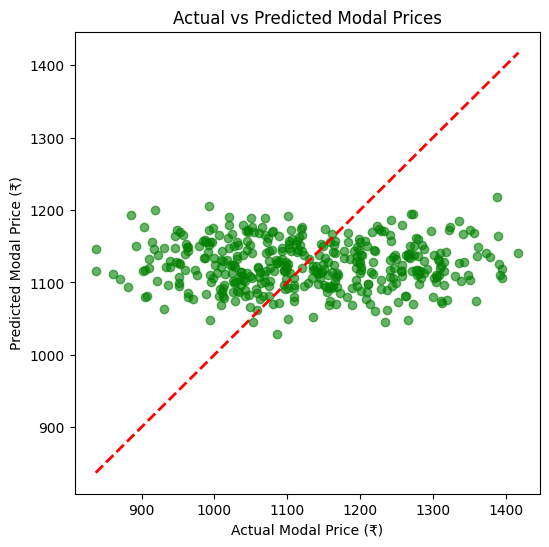

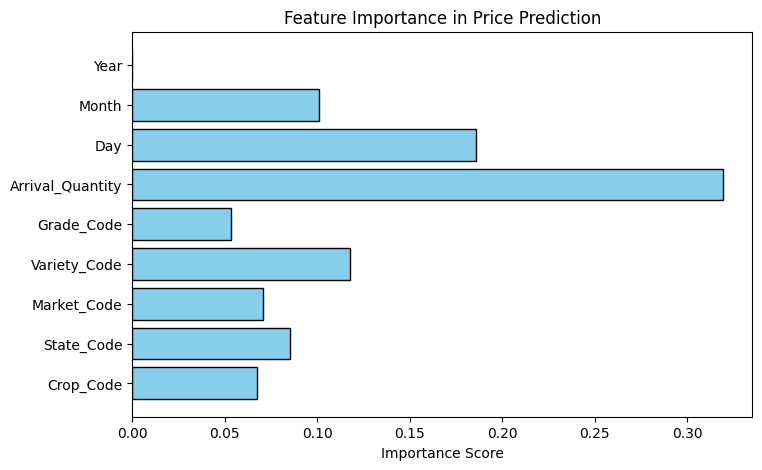

In [11]:
# 📊 Visualization 1 — Actual vs Predicted Prices
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, color="green", alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual Modal Price (₹)")
plt.ylabel("Predicted Modal Price (₹)")
plt.title("Actual vs Predicted Modal Prices")
plt.show()

# 📈 Visualization 2 — Feature Importance
importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(8, 5))
plt.barh(features, importances, color="skyblue", edgecolor="black")
plt.xlabel("Importance Score")
plt.title("Feature Importance in Price Prediction")
plt.show()


In [12]:
import joblib

# ✅ Save trained Random Forest model
joblib.dump(model, "price_model.pkl")

# ✅ Save all encoders separately
joblib.dump(le_crop, "crop_encoder.pkl")
joblib.dump(le_state, "state_encoder.pkl")
joblib.dump(le_market, "market_encoder.pkl")
joblib.dump(le_variety, "variety_encoder.pkl")
joblib.dump(le_grade, "grade_encoder.pkl")

print("✅ Model and all encoders saved successfully!")


✅ Model and all encoders saved successfully!


In [13]:
!ls -lh *.pkl


-rw-r--r-- 1 root root 534 Nov  4 16:22 crop_encoder.pkl
-rw-r--r-- 1 root root 485 Nov  4 16:22 grade_encoder.pkl
-rw-r--r-- 1 root root 529 Nov  4 16:22 market_encoder.pkl
-rw-r--r-- 1 root root 28M Nov  4 16:22 price_model.pkl
-rw-r--r-- 1 root root 534 Nov  4 16:22 state_encoder.pkl
-rw-r--r-- 1 root root 626 Nov  4 16:22 variety_encoder.pkl


In [14]:
from google.colab import files

# ✅ Download model and encoder files
files.download("price_model.pkl")
files.download("crop_encoder.pkl")
files.download("state_encoder.pkl")
files.download("market_encoder.pkl")
files.download("variety_encoder.pkl")
files.download("grade_encoder.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
import joblib
import numpy as np

# ✅ Step 1: Load saved model and encoders
model = joblib.load("price_model.pkl")
le_crop = joblib.load("crop_encoder.pkl")
le_state = joblib.load("state_encoder.pkl")
le_market = joblib.load("market_encoder.pkl")
le_variety = joblib.load("variety_encoder.pkl")
le_grade = joblib.load("grade_encoder.pkl")

print("✅ Model and encoders loaded successfully!\n")

# ✅ Step 2: Provide sample input (you can change these)
sample_crop = "Wheat"
sample_state = "Gujarat"
sample_market = "Main Mandi"
sample_variety = "Desi"
sample_grade = "B"
sample_arrival = 50.0
sample_day = 5
sample_month = 9
sample_year = 2026

# ✅ Step 3: Encode categorical inputs
encoded_crop = le_crop.transform([sample_crop])[0]
encoded_state = le_state.transform([sample_state])[0]
encoded_market = le_market.transform([sample_market])[0]
encoded_variety = le_variety.transform([sample_variety])[0]
encoded_grade = le_grade.transform([sample_grade])[0]

# ✅ Step 4: Prepare the input for prediction
input_data = np.array([[encoded_crop, encoded_state, encoded_market, encoded_variety,
                        encoded_grade, sample_arrival, sample_day, sample_month, sample_year]])

# ✅ Step 5: Make prediction
predicted_price = model.predict(input_data)[0]

print(f"💰 Predicted Modal Price for {sample_crop} in {sample_state} ({sample_market}, {sample_variety}, Grade {sample_grade}): ₹{predicted_price:.2f}")


✅ Model and encoders loaded successfully!

💰 Predicted Modal Price for Wheat in Gujarat (Main Mandi, Desi, Grade B): ₹1174.17


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
